# Last Query Transformer RNN

- Riiid! 대회의 1st place 를 차지한 모델을 직접 구현해본다

In [1]:
import os, random, pickle
from tqdm import tqdm
from datetime import datetime as dt
from easydict import EasyDict

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from dataset import SimpleSequenceDKTDataset
from models.models import LastQueryTransformerRNN

import wandb

plt.rcParams["font.family"] = 'NanumGothic'

In [2]:
SimpleSequenceDKTDataset

dataset.SimpleSequenceDKTDataset

In [3]:
# fix random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
_ = torch.manual_seed(seed)

# Configs

In [4]:
import yaml

#read yaml file
with open('rnn_config.yaml') as file:
  config = yaml.safe_load(file)
print(config)

{'modelname': 'lastquery', 'result_dir': '.', 'data_dir': 'dataset/', 'data_name': 'dataset_v4-128-False-22.pt', 'max_length': 512, 'embed': False, 'wandb_config': {'wandb': True, 'project_name': 'dkt-dl'}, 'train_config': {'batch_size': 16, 'emb_dim': 128, 'hidden_dim': 128, 'activation_f': 'tanh', 'learnin_rate': 0.001, 'epochs': 1, 'patience': 10, 'CosineAnnealingLR': {'T_max': 10, 'eta_min': 0}, 'StepLR': {'step_size': 2, 'gamma': 0.1}, 'CosineAnnealingWarmRestarts': {'T_0': 1, 'T_mult': 1, 'eta_min': 0}}}


In [5]:
# with open('512-False-embeddings.pickle', 'rb') as f:
#         embeddings = EasyDict(pickle.load(f))

## wandb logging

In [6]:
import wandb

# run name condition
now = dt.strftime(dt.now(), '%y%m%d-%H%M%S')

if config['wandb_config']['wandb']:
    run = wandb.init(
        project=config['wandb_config']['project_name'],
        name=f'{config["modelname"]}_{now}',
        config={
        'data_name': config['data_name'],
        **config['train_config'],
    })

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: twndus (dkt-recsys1). Use `wandb login --relogin` to force relogin


# load dataset

In [7]:
data_dir = config['data_dir']
data_name = config['data_name']

train_dataset_v1 = torch.load(os.path.join(data_dir, f'train_{data_name}'))
valid_dataset_v1 = torch.load(os.path.join(data_dir, f'valid_{data_name}'))
test_dataset_v1 = torch.load(os.path.join(data_dir, f'test_{data_name}'))

In [8]:
max_length = config['max_length'] #128 #512
embed = config['embed']#True

In [9]:
len(train_dataset_v1), len(valid_dataset_v1), train_dataset_v1[0]['X'][1]

(5358,
 1340,
 array([ 5.60000000e+02,  1.09000000e+02,  5.22000000e+02,  0.00000000e+00,
         1.09000000e+02,  1.00000000e+00,  5.00000000e+00,  1.00000000e+00,
        -7.99883474e-01,  2.53394885e-01,  2.00000000e+00,  8.91396333e-01,
         8.66195839e-01,  9.25714286e-01,  8.75787064e-01,  8.02021862e-01,
         8.02021862e-01,  1.27782247e-01,  3.01784916e-02, -5.26582487e-02,
         3.01784916e-02,  3.01784916e-02]))

# dataloader

In [10]:
batch_size = config['train_config']['batch_size']
train_dataloader = DataLoader(train_dataset_v1, batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset_v1, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset_v1, batch_size)

# Modeling

In [11]:
############# 변경 필요 (사용하는 피처들로 구성)
category_cols = [
    'assessmentItemID', 'testId', 'KnowledgeTag',
    'test_group_one', 'test_group_two', 'serial',
    'dayofweek', 'time_hour'
]
scaling_cols = ['time_diff', 'timediff']
features = [*category_cols, *scaling_cols, 
            'previous_label',
            # 'acc_window_3', 'acc_window_5', 'acc_window_10',
            'user_acc_mean', 'tag_acc_mean', 'item_acc_mean', 'test_acc_mean',
            'g1_acc_mean', 'g1_acc_mean',
            'user_time_median', 'tag_time_median', 'item_time_median', 
            'g1_time_median', 'g2_time_median',  
            # 'user_count', 'user_ability', 'tag_difficulty', 
            # 'item_difficulty', 'test_difficulty', 'g1_difficulty', 'g2_difficulty',
            # 'guess_yn',
]

In [12]:
cat_size = len(category_cols)
############# 변경 필요 (command 복붙)
cat_emb_size = [
    9454, 1537, 912, 
    9, 198, 13,
    7, 6,
]

num_size = len(features)-cat_size
len(features), cat_size, num_size

(22, 8, 14)

In [13]:
learning_rate = config['train_config']['learnin_rate']

seqlen = max_length# 256 #DATA
emb_dim = config['train_config']['emb_dim']
hidden_dim = config['train_config']['hidden_dim']
activation_f = config['train_config']['activation_f']

num_heads = 4
dropout_ratio = 0.5

In [14]:
features, cat_size, num_size, cat_emb_size, emb_dim, hidden_dim, num_heads, dropout_ratio, activation_f, seqlen,

(['assessmentItemID',
  'testId',
  'KnowledgeTag',
  'test_group_one',
  'test_group_two',
  'serial',
  'dayofweek',
  'time_hour',
  'time_diff',
  'timediff',
  'previous_label',
  'user_acc_mean',
  'tag_acc_mean',
  'item_acc_mean',
  'test_acc_mean',
  'g1_acc_mean',
  'g1_acc_mean',
  'user_time_median',
  'tag_time_median',
  'item_time_median',
  'g1_time_median',
  'g2_time_median'],
 8,
 14,
 [9454, 1537, 912, 9, 198, 13, 7, 6],
 128,
 128,
 4,
 0.5,
 'tanh',
 512)

In [15]:
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LastQueryTransformerRNN(features, cat_size, num_size, cat_emb_size, 
    emb_dim, hidden_dim, num_heads, dropout_ratio, activation_f, seqlen,
    ).to(device)

loss_f = nn.BCEWithLogitsLoss().to(device)
adamw = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(adamw, step_size=5, gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adamw, patience=10, factor=0.5, mode='max', verbose=True)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(adamw, **config['train_config']['CosineAnnealingLR'])
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(adamw, T_max=T_max, eta_min=eta_min)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
#     adamw, **config['train_config']['CosineAnnealingWarmRestarts'])

In [16]:
from copy import deepcopy
from sklearn.metrics import roc_auc_score, accuracy_score

def train_step(model, loss_f, train_dataloader, adamw, device):
    loss_sum, auc_sum, acc_sum = 0, 0, 0

    for iter, data in enumerate(train_dataloader):

        user_ids, X = data['user_id'].int().to(device), data['X'].float().to(device)
        y = data['y'].view(data['y'].size(0), 1).float().to(device)
        mask = data['mask'].float().to(device)
        
        pred = model((user_ids, X, mask))
        # pred = model((X, mask))
        loss = loss_f(pred, y)
        
        adamw.zero_grad()
        loss.backward()
        adamw.step()

        auc_sum += roc_auc_score(y.detach().cpu().numpy(), torch.sigmoid(pred).detach().cpu().numpy())
        acc_sum += accuracy_score(y.detach().cpu().numpy(), torch.sigmoid(pred).detach().cpu().int().numpy()>=0.5)
        loss_sum += loss.item()
    
    # scheduler.step()
    
    return loss_sum/len(train_dataloader), auc_sum/len(train_dataloader), acc_sum/len(train_dataloader)

def valid_step(model, loss_f, valid_dataloader, device):
    loss_sum = 0
    auc_sum = 0
    acc_sum = 0
    targets, preds = [], []

    for iter, data in enumerate(valid_dataloader):
        user_ids, X = data['user_id'].int().to(device), data['X'].float().to(device)
        y = data['y'].view(data['y'].size(0), 1).float().to(device)
        mask = data['mask'].float().to(device)
        pred = model((user_ids, X, mask))
        
        loss = loss_f(pred, y)

        auc_sum += roc_auc_score(y.detach().cpu().numpy(), torch.sigmoid(pred).detach().cpu().numpy())
        acc_sum += accuracy_score(y.detach().cpu().numpy(), torch.sigmoid(pred).detach().cpu().numpy()>=0.5)
        loss_sum += loss.item()

        targets.extend(data['y'].detach().numpy())
        preds.extend(torch.sigmoid(pred).detach().cpu().numpy())
        
    return targets, preds, loss_sum/len(valid_dataloader), auc_sum/len(valid_dataloader), acc_sum/len(valid_dataloader)

In [17]:
epochs = config['train_config']['epochs']
best_auc, best_epochs = 0, 0
least_loss, patience, num = 1e+9, config['train_config']['patience'], 0
best_model = None

torch.autograd.set_detect_anomaly(True)

for e in range(epochs):

    train_loss, train_auc, train_acc = train_step(model, loss_f, train_dataloader, adamw, device)
    _, _, valid_loss, valid_auc, valid_acc = valid_step(model, loss_f, valid_dataloader, device)

    print(f'[{e} epochs] train_loss: {train_loss:.4f}, valid_loss: {valid_loss:.4f}, train_auc: {train_auc:.4f}, valid_auc: {valid_auc:.4f}, valid_auc: {valid_acc:.4f}, valid_acc: {valid_acc:.4f}')
    
    if config['wandb_config']['wandb']:
        wandb.log({"train_loss": train_loss, "valid_loss": valid_loss,
                "train_auc": train_auc, "valid_auc": valid_auc})
    
    if valid_loss < least_loss:
        print(f'minimum valid loss is {valid_loss:.4f} at {e} epoch')
        least_loss, num = valid_loss, 0
        best_auc, best_epochs = valid_auc, e
        best_model = deepcopy(model.state_dict())
    else:
        num += 1
        if num >= patience:
            print(f'early stopped at {e} epoch')
            break
    
    lr_scheduler.step(valid_loss)

[0 epochs] train_loss: 0.5949, valid_loss: 0.5164, train_auc: 0.7568, valid_auc: 0.8240, valid_auc: 0.7413, valid_acc: 0.7413
minimum valid loss is 0.5164 at 0 epoch


In [18]:
model.load_state_dict(best_model)
targets, preds, valid_loss, valid_auc, valid_acc = valid_step(model, loss_f, valid_dataloader, device)
_, _, train_loss, train_auc, train_acc = valid_step(model, loss_f, train_dataloader, device)
best_epochs, best_auc, train_auc, valid_auc, train_acc, valid_acc, best_epochs

(0,
 0.8239622164101329,
 0.8250483067927094,
 0.8290632606480821,
 0.7450426439232409,
 0.7418154761904762,
 0)

In [19]:
if config['wandb_config']['wandb']:
    run.log({
        "final_train_auc": train_auc,
        "final_valid_auc": valid_auc,
    })

In [20]:
from sklearn.metrics import confusion_matrix
confusion_matrix(targets, np.array(preds) > 0.5)

array([[512, 186],
       [159, 483]])

(array([126., 125., 119., 119., 119., 145., 130., 173., 211.,  73.]),
 array([0.01623713, 0.10568243, 0.19512773, 0.28457302, 0.37401834,
        0.46346363, 0.55290896, 0.64235425, 0.73179954, 0.82124484,
        0.91069013]),
 <BarContainer object of 10 artists>)

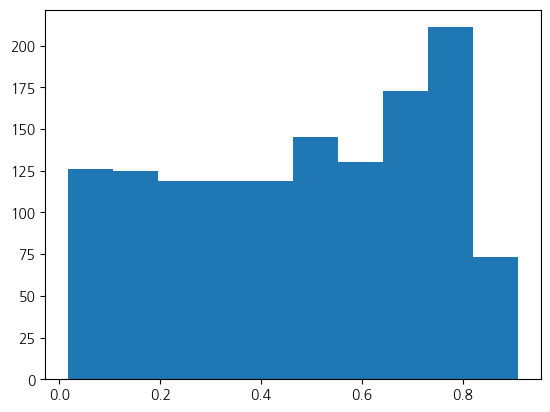

In [21]:
plt.hist([pred[0] for pred in preds])

In [22]:
from sklearn.metrics import roc_curve, auc
# ROC 곡선 계산
fpr, tpr, thresholds = roc_curve(targets, preds)
roc_auc = auc(fpr, tpr)

# 최적의 임계값 찾기
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.47416776

In [23]:
preds_ = [int(pred > optimal_threshold) for pred in preds]

if config['wandb_config']['wandb']:
    run.log({
        "confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=targets, preds=preds_,
            class_names=['0', '1'])})

    # finish wandb run
    run.finish()

/tmp/ipykernel_383411/3411821847.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  preds_ = [int(pred > optimal_threshold) for pred in preds]
wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


final_train_auc,▁
final_valid_auc,▁
train_auc,▁
train_loss,▁
valid_auc,▁
valid_loss,▁
final_train_auc,0.82505
final_valid_auc,0.82906
train_auc,0.75679
train_loss,0.59488
valid_auc,0.82396


In [24]:
# test auc
def test_step(model, test_dataloader, device):
    user_ids_, test_pred_proba = [], []
    for iter, data in enumerate(test_dataloader):
        user_ids, X = data['user_id'].int().to(device), data['X'].float().to(device)
        mask = data['mask'].float().to(device)
        pred = model((user_ids, X, mask))

        # user_id = data['user_id'].int().to(device)
        # X = data['X'].float().to(device)
        # mask = data['mask'].float().to(device)
        # pred = model((user_id, X, mask))

        user_ids_.extend(data['user_id'].detach().numpy())
        test_pred_proba.extend(torch.sigmoid(pred).detach().cpu().numpy())
        
    return user_ids, test_pred_proba

In [25]:
user_ids, test_pred_proba = test_step(model, test_dataloader, device)

In [26]:
submission_df = pd.read_csv('../../data/sample_submission.csv')
submission_df.prediction = np.array(test_pred_proba)

(array([ 64.,  69.,  77.,  63.,  67.,  58.,  85.,  99., 113.,  49.]),
 array([0.0153069 , 0.10472888, 0.19415088, 0.28357285, 0.37299484,
        0.46241683, 0.55183882, 0.6412608 , 0.73068279, 0.82010478,
        0.90952677]),
 <BarContainer object of 10 artists>)

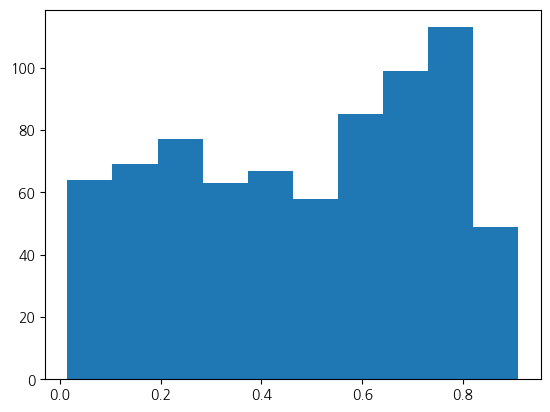

In [27]:
plt.hist(np.array(test_pred_proba))

In [28]:
result_dir = config['result_dir']
# now = dt.strftime(dt.now(), '%y%m%d-%H%M%S')
modelname = config['modelname']
savename = f'{modelname}_{now}_{valid_auc:.4f}.csv'
submission_df.to_csv(os.path.join(result_dir, savename), index=False)

In [29]:
savename

'lastquery_240122-050616_0.8291.csv'